In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("insurance.csv")
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
print(df.isnull().sum())

print(df.info())

print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

df['sex'] = df['sex'].str.strip().str.lower()
df['smoker'] = df['smoker'].str.strip().str.lower()
df['region'] = df['region'].str.strip().str.lower()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


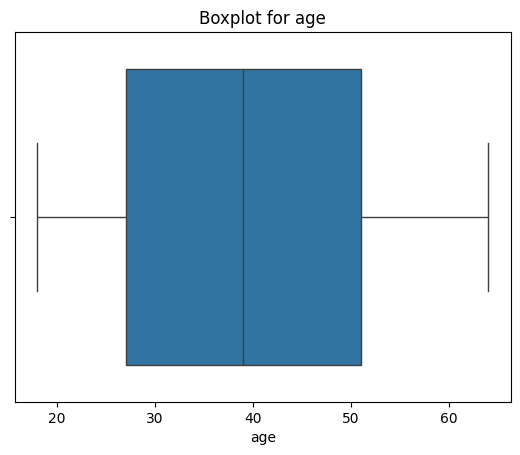

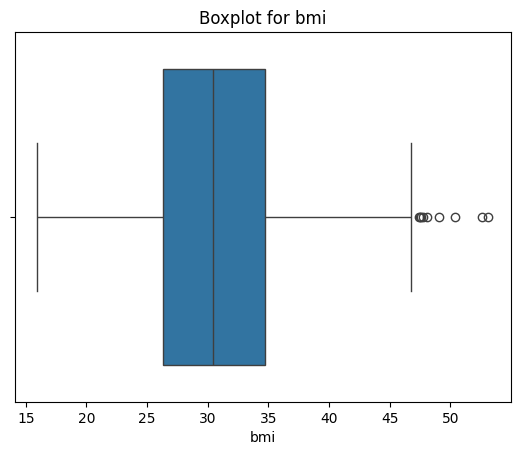

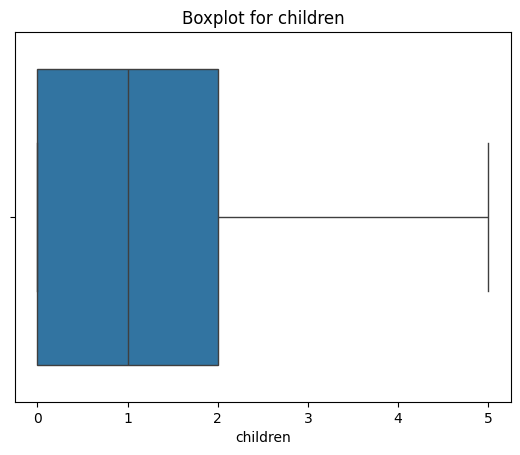

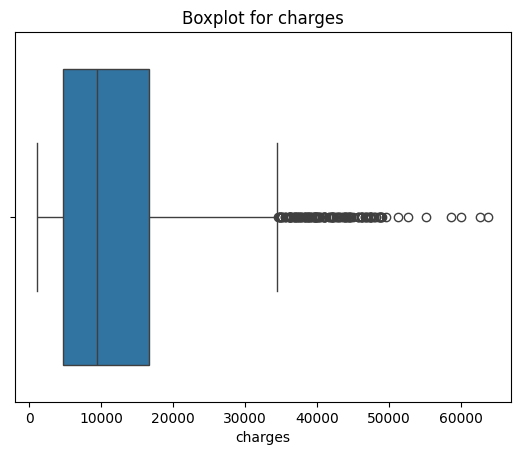

(1191, 7)


In [ ]:
numeric_cols = ['age', 'bmi', 'children', 'charges']
for col in numeric_cols:
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot for {col}")
    plt.show()

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df_clean = df.copy()
for col in ['bmi', 'charges']:
    df_clean = remove_outliers(df_clean, col)

print(df_clean.shape)


In [ ]:
df_encoded = pd.get_dummies(df_clean, drop_first=True)
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [ ]:
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Info Ranking:\n", mi_series)

rf = RandomForestRegressor()
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Random Forest Importance:\n", rf_importances)


Mutual Info Ranking:
 age                 1.603024
smoker_yes          0.210746
sex_male            0.196610
children            0.171498
region_northwest    0.058453
region_southeast    0.036092
bmi                 0.025257
region_southwest    0.004325
dtype: float64
Random Forest Importance:
 smoker_yes          0.357550
age                 0.335784
bmi                 0.201042
children            0.048298
region_northwest    0.016462
sex_male            0.014908
region_southeast    0.014190
region_southwest    0.011766
dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    print(f"{name} - R2: {r2:.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")


Linear Regression - R2: 0.6328, RMSE: 4458.44
Ridge - R2: 0.6341, RMSE: 4450.56
Random Forest - R2: 0.6273, RMSE: 4491.73


In [ ]:
top_features = mi_series.head(3).index.tolist()
X_top = df_encoded[top_features]

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train_top, y_train_top)
    preds = model.predict(X_test_top)
    r2 = r2_score(y_test_top, preds)
    print(f"{name} on Top 3 - R2: {r2:.4f}, RMSE: {np.sqrt(mean_squared_error(y_test_top, preds)):.2f}")


Linear Regression on Top 3 - R2: 0.6115, RMSE: 4585.97
Ridge on Top 3 - R2: 0.6130, RMSE: 4576.96
Random Forest on Top 3 - R2: 0.5809, RMSE: 4763.03


In [ ]:
results = pd.DataFrame({
    "Model": ["Linear", "Ridge", "RF", "Linear Top3", "Ridge Top3", "RF Top3"],
    "R² Score": [0.6328, 0.6341, 0.6273, 0.6115, 0.6130, 0.5809],
    "RMSE": [4458.44, 4450.56, 4491.73, 4585.97, 4576.96, 4763.03]
})
results

,Model,R² Score,RMSE
0,Linear,0.6328,4458.44
1,Ridge,0.6341,4450.56
2,RF,0.6273,4491.73
3,Linear Top3,0.6115,4585.97
4,Ridge Top3,0.6130,4576.96
5,RF Top3,0.5809,4763.03
